In diesem kleinen Notebook werden wir anhand der Seite https://imdb.com die Qualität unserer Lieblingsserie im Laufe mehrere Staffeln untersuchen. Dazu werden wir

- Die IMDB ID unserer Lieblingsserie ermitteln
- Anhand der IMDB ID nach der Serie untersuchen, wie viele Staffeln der Serie es gibt.
- Anhand der IMDB ID für eine Staffel die Durchschnittsbewertung und Anzahl der insgesamt abgegebenen Bewertungen je Episode auslesen.



In [1]:
#!/usr/bin/env python3

import re
from bs4 import BeautifulSoup
from requests import get
import matplotlib.pyplot as plt
import numpy as np


def extract_imdb_id(s: str) -> str:
    """ Extrahiert aus einem einem str 'title/tt121345/bla' 
        die IMDB id tt12345 und gibt diese zurück. """
    return re.search("/title/(.*)/", s).group(1)


def extract_num_seasons(s: str) -> int:
    """ Extrahiert aus einem String, der mit einer Zahl beginnt, 
        diese Zahl und gibt diese als int zurück."""
    return int(re.search(r"^\d*", s).group(0))


def extract_num_votes(s: str) -> int:
    """ Extrahiert aus einem String '(1234,2345)' die Zahl und 
        gibt diese Zurück (achtung: anglistisch Format) """
    return int(re.search("[0-9]+,*[0-9]+", s).group(0).replace(",", ""))

**2. Schreibe eine Funktion `scrape_imdb_id(name: str) -> str`, welche den Seriennamen als Argument besitzt und die IMDB ID
als String zurückgibt.**

- Hinweis1: Der Einfachheithalber kannst du davon ausgehen, dass deine Lieblingsserie als oberstes Suchergebnis angezeigt wird. 
- Hinweis2: Jede Serie ist mit *(TV Series)* gekennzeichnet und kann daher klar von Filmen unterschieden werden.

In [16]:
def scrape_imdb_id(name: str) -> str:
    nameplus = name.lower().replace(" ", "+")
    search_url = f"https://www.imdb.com/find?q={nameplus}"
    html_code = get(search_url).content
    soup = BeautifulSoup(html_code)
    imdb_id_str = soup.find("tr", class_="findResult odd").a["href"]
    return extract_imdb_id(imdb_id_str)

In [18]:
imdb_id = scrape_imdb_id("Game of Thrones")

**3. Analysiere, wie man die Anzahl der Staffeln deiner Serie *scrapen* könnte und implementiere eine Funktion `scrape_num_seasons(imdb_id: str) -> int`, welche die IMDB ID als Argument erwartet und die Anzahl der Staffeln als zurückgibt.**

In [20]:
def scrape_num_seasons(imdb_id: str) -> int:
    url = f"https://www.imdb.com/title/{imdb_id}/?ref_=fn_al_tt_1"
    soup = BeautifulSoup(get(url).content)
    select_tag = soup.find("select", id="browse-episodes-season")
    return extract_num_seasons(select_tag["aria-label"])

In [22]:
scrape_num_seasons(imdb_id)

8

**4.Analysiere, wie man die Durchschnittsbewertung jeder einzelnen Episode einer Staffel und die Anzahl der abgegebenen Bewertungen *parsen* könnte. Implementiere anschließend eine Funktion `scrape_ratings(imdb_id: str, season: int) -> Tuple[List[float], List[int]]`, welche für die Staffel `season` die Durchschnittsbewertungen aller Folgen und die jeweilige Anzahl der abgegeben Bewertungen jeweils als Liste zurückgibt.**

In [25]:
from typing import Tuple, List

def scrape_ratings(imdb_id: str, season: int) -> Tuple[List[float], List[int]]:
    url = f"https://www.imdb.com/title/{imdb_id}/episodes?season={season}&ref_=tt_eps_sn_1"
    soup = BeautifulSoup(get(url).content)
    div_tags = soup.find_all("div", class_="ipl-rating-star small")
    ratings, total_votes = [], []
    for div in div_tags:
        rating = float(div.find("span", class_="ipl-rating-star__rating").text)
        votes = extract_num_votes(div.find("span", class_="ipl-rating-star__total-votes").text)
        ratings.append(rating)
        total_votes.append(votes)
    return ratings, total_votes

In [26]:
scrape_ratings(imdb_id, 1)

([9.1, 8.8, 8.7, 8.8, 9.1, 9.2, 9.2, 9.0, 9.6, 9.5],
 [44550, 33910, 32113, 30538, 31753, 31412, 31936, 29879, 41683, 36731])

**5. Probiere deine implementierten Funktionen aus, indem du dir die Bewertungen deiner Lieblingsserie plottest**

In [27]:
def plot_ratings(serienname: str, regress_all=False) -> None:
    imdb_id = scrape_imdb_id(serienname)
    num_seasons = scrape_num_seasons(imdb_id)
    # Für den Plot
    plt.title(serienname)
    plt.xlabel("Episode")
    plt.ylabel("Rating")
    k = 0
    all_ratings = []
    for season in range(1, num_seasons + 1):
        ratings, num_votes = scrape_ratings(imdb_id, season)
        episodes = np.arange(len(ratings)) + k
        k += len(ratings)
        p = plt.plot(episodes, ratings, ".", label=f"Staffel {season}")
        # Koeffizienten der Regressionsgerade
        coefs = np.polyfit(episodes, ratings, 1)
        plt.plot(episodes, np.poly1d(coefs)(episodes), color=p[0].get_color())
        if regress_all:
            all_ratings += ratings
    # Regression über alle Staffeln
    if regress_all:
        all_episodes = np.arange(len(all_ratings))
        coefs = np.polyfit(all_episodes, all_ratings, 1)
        plt.plot(all_episodes, np.poly1d(coefs)(all_episodes), "--", label="Alle Staffeln")
    plt.legend()
    plt.show()

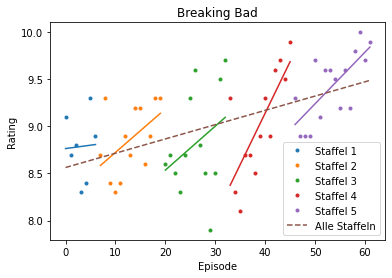

In [29]:
plot_ratings("Breaking Bad", regress_all=True)